In [3]:
import os
import sys
import json
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma'
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import glob
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points
from nuscenes.nuscenes import NuScenes
from nuscenes.nuscenes import NuScenesExplorer
import os

from pyquaternion import Quaternion

In [4]:
data_dir = '../Nusc/v1.0-mini'
nusc = NuScenes(version='v1.0-mini', dataroot=data_dir, verbose=True)
nusc_exp = NuScenesExplorer(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.610 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
Normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225]
)

In [5]:
nusc.dataroot

'../Nusc/v1.0-mini'

In [3]:
class nuScenesDataset(Dataset):
    def __init__(self, dataset_dir='/workspace/data/nuscenes', split='train', cam='CAM_FRONT', target_image_size=(224,400), context=[0,0], depth_range=[1e-2,100], normalize=False):
        self.split = split
        if split == 'train':
            version = 'v1.0-trainval'
        else:
            version = 'v1.0-test'
        self.nusc = NuScenes(version=version, dataroot=dataset_dir, verbose=True)
        self.cam = cam
        self.target_image_size = target_image_size
        self.context = context
        self.has_context = context[0]+context[1] > 0
        self.min_depth = depth_range[0]
        self.max_depth = depth_range[1]
        self.normalize = normalize
        
    def __len__(self) -> int:
        return len(self.nusc.sample)
    
    def compute_target_intrinsics(self, intrinsics, scale_down=False):
        if scale_down:
            return np.array([[0.5, 0, 0], [0, 0.5, 0], [0, 0, 1]]) @ intrinsics
        return np.array([[self.target_image_size[1]/1600., 0, 0], [0, self.target_image_size[0]/900., 0], [0, 0, 1]]) @ intrinsics
    
    def generate_depth_from_lidar(self, pc, cam_intrinsics):
        depths = pc.points[2, :]
        points = view_points(pc.points[:3, :], np.array(cam_intrinsics), normalize=True)
        
        mask = np.ones(depths.shape[0], dtype=bool)
        mask = np.logical_and(mask, depths > self.min_depth)
        mask = np.logical_and(mask, points[0, :] > 1)
        mask = np.logical_and(mask, points[0, :] < self.target_image_size[1] - 1)
        mask = np.logical_and(mask, points[1, :] > 1)
        mask = np.logical_and(mask, points[1, :] < self.target_image_size[0] - 1)
        depths = depths[mask]
        points = points[:, mask]

        # Create depth map
        depth = np.zeros((self.target_image_size))
        depth[points[1].astype(np.int32), points[0].astype(np.int32)] = depths

        return depth
    
    def preprocess_image(self, img: Image.Image):
        img = img.resize((self.target_image_size[1], self.target_image_size[0]), resample=Image.Resampling.BILINEAR)
        
        img = np.array(img).astype(np.float32)/255
        
        preprocess = transforms.Compose([transforms.ToTensor(),
                                        ])
        image_tensor = preprocess(img)
        
        if self.normalize:
            image_tensor = Normalize(image_tensor)
        
        del img
        return image_tensor
    
    def __getitem__(self, index: int):
        sample = self.nusc.sample[index]
        lidar = self.nusc.get('sample_data', sample['data']['LIDAR_TOP'])
        cam =  self.nusc.get('sample_data', sample['data'][self.cam])
        
        pc = LidarPointCloud.from_file(os.path.join(self.nusc.dataroot, lidar['filename']))
        
        # Points live in the lidar frame. So they need to be transformed via global to the image plane.
        # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
        cs_record = self.nusc.get('calibrated_sensor', lidar['calibrated_sensor_token'])
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
        pc.translate(np.array(cs_record['translation']))

        # Second step: transform from ego to the global frame.
        poserecord = self.nusc.get('ego_pose', lidar['ego_pose_token'])
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
        pc.translate(np.array(poserecord['translation']))

        # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
        poserecord = self.nusc.get('ego_pose', cam['ego_pose_token'])
        pc.translate(-np.array(poserecord['translation']))
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

        # Fourth step: transform from ego into the camera.
        cs_record = self.nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        pc.translate(-np.array(cs_record['translation']))
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
        
        intrinsics = self.compute_target_intrinsics(np.array(cs_record['camera_intrinsic']))
        depth = self.generate_depth_from_lidar(pc, intrinsics)
        # scale_down = transforms.Resize(size = [self.target_image_size[0]//2,self.target_image_size[1]//2])
        
        keyframe = self.preprocess_image(Image.open(os.path.join(self.nusc.dataroot, cam['filename'])))
        data = {
            "keyframe": keyframe,
            "depth": depth,
        }
        
        return data

In [4]:
nuscenes = nuScenesDataset(split='test')

Loading NuScenes tables for version v1.0-test...
23 category,
8 attribute,
4 visibility,
0 instance,
12 sensor,
1800 calibrated_sensor,
462901 ego_pose,
15 log,
150 scene,
6008 sample,
462901 sample_data,
0 sample_annotation,
4 map,
Done loading in 3.571 seconds.
Reverse indexing ...
Done reverse indexing in 1.1 seconds.


In [5]:
data_dict = nuscenes[0]

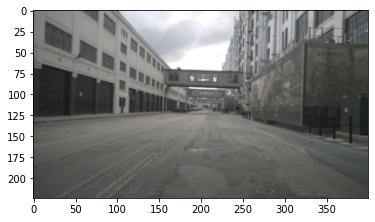

In [6]:
plt.imshow(data_dict['keyframe'].permute(1,2,0))

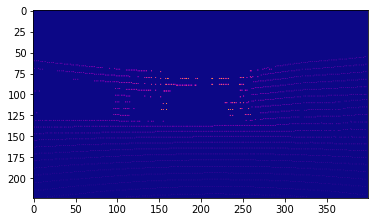

In [7]:
plt.imshow(data_dict['depth'])